In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
import pickle
import os
import sys
import copy
from cleanlab import noise_generation

pp_path = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(pp_path)
os.environ["PYTHONPATH"] = pp_path + ":" + os.environ.get("PYTHONPATH", "")
from utils import *
pd.options.mode.chained_assignment = None # None / 'warn'
pd.set_option('display.max_columns', None)

In [2]:
### read dataset

# source: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
datapath = '../data_raw/CreditFraud/creditcard.csv'
df = pd.read_csv(datapath)
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
# check for missing values

df.isnull().sum().sum()

0

In [5]:
vc = df['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(df), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


In [6]:
### subsampling
seed = 0

fraud = df[df['Class']==1]
non_fraud = df[df['Class']==0].sample(2*len(fraud), random_state=seed)
df = non_fraud.append(fraud).reset_index(drop=True)

In [7]:
### preprocessing columns

df.rename(columns={"Class":"Target"}, inplace=True)

print('\ndata shape: ', df.shape, sep='')
print('\ncolumn names:\n', list(df.columns), sep='')
print('\nclass distribution:\n', df.Target.value_counts(), sep='')
print('\ncolumn types:\n', df.dtypes, sep='')


data shape: (1476, 31)

column names:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Target']

class distribution:
0    984
1    492
Name: Target, dtype: int64

column types:
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Target      int64
dtype: object


In [8]:
categorical_features = [] ###
continuous_features = list(OrderedSet(df.columns.to_list()) - OrderedSet(["Target"]) - OrderedSet(categorical_features))
print('continuous_features:', continuous_features)
print('\ncategorical_features:', categorical_features)

continuous_features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

categorical_features: []


In [9]:
df.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Target
count,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.000000,1476.00000,1476.000000
mean,88893.283198,-1.542497,1.161087,-2.325293,1.564634,-1.047112,-0.454697,-1.822308,0.206055,-0.888797,-1.870713,1.292622,-2.111504,-0.053024,-2.302896,-0.036456,-1.373505,-2.202216,-0.749776,0.230103,0.128378,0.243278,-0.006357,-0.013126,-0.040478,0.018306,0.023311,0.043793,0.031543,105.31357,0.333333
std,47006.446980,4.786261,3.306134,5.417572,2.944718,3.607799,1.640422,5.007332,3.990939,2.067628,3.983416,2.496171,4.056185,1.043967,4.187540,0.959286,3.042033,5.147769,2.089616,1.165978,1.062182,2.307742,1.038075,1.068696,0.580712,0.610935,0.478323,0.861357,0.376889,296.36086,0.471564
min,406.000000,-30.552380,-18.793329,-31.103685,-4.704106,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,-2.509339,-18.683715,-3.844974,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-3.681904,-8.671891,-22.797604,-8.887017,-19.254328,-2.409839,-4.781606,-1.196621,-7.263482,-1.869290,0.00000,0.000000
25%,48309.000000,-1.849756,-0.361527,-2.865399,-0.487805,-1.236667,-1.169864,-1.567073,-0.203355,-1.574411,-2.671041,-0.428225,-3.118491,-0.761596,-4.288310,-0.600846,-1.926788,-1.459138,-1.102556,-0.427506,-0.212885,-0.191572,-0.543069,-0.210636,-0.379968,-0.304659,-0.298825,-0.068252,-0.059156,2.49750,0.000000
50%,81101.000000,-0.453766,0.506087,-0.609895,0.662464,-0.260141,-0.501973,-0.279514,0.089940,-0.419299,-0.399576,0.619097,-0.344346,-0.022373,-0.330185,-0.010273,-0.230063,-0.285894,-0.189258,0.132859,-0.014556,0.056807,-0.008737,-0.029419,0.017260,0.038024,-0.020646,0.024056,0.023526,19.60000,0.000000
75%,134293.250000,1.169290,1.659748,0.686037,3.029147,0.522829,0.180697,0.398162,0.632319,0.312705,0.226454,2.173540,0.379026,0.652913,0.306940,0.643499,0.401995,0.334726,0.404885,0.780857,0.318888,0.412571,0.528669,0.163747,0.377736,0.371258,0.298823,0.262016,0.152498,98.91250,1.000000
max,172607.000000,2.354104,22.057729,4.069865,12.114672,11.095089,7.478806,16.303141,20.007208,5.133738,8.403938,12.018913,3.818195,2.980138,4.065274,2.471358,3.139656,6.739384,3.886176,5.228342,11.717431,27.202839,8.361985,10.377233,1.347381,3.127398,2.745261,3.052358,3.572542,5680.00000,1.000000


In [10]:
# shuffle and split data into train/(val)/test
seed = 0

train_fraction = 0.75 ###
df_train, df_test = shuffle_split_data(df, train_fraction, seed=seed)

print('train:', df_train.shape)
print(np.unique(df_train.Target, return_counts=True))
print('\ntest:', df_test.shape)
print(np.unique(df_test.Target, return_counts=True))

train: (1107, 31)
(array([0, 1]), array([738, 369]))

test: (369, 31)
(array([0, 1]), array([246, 123]))


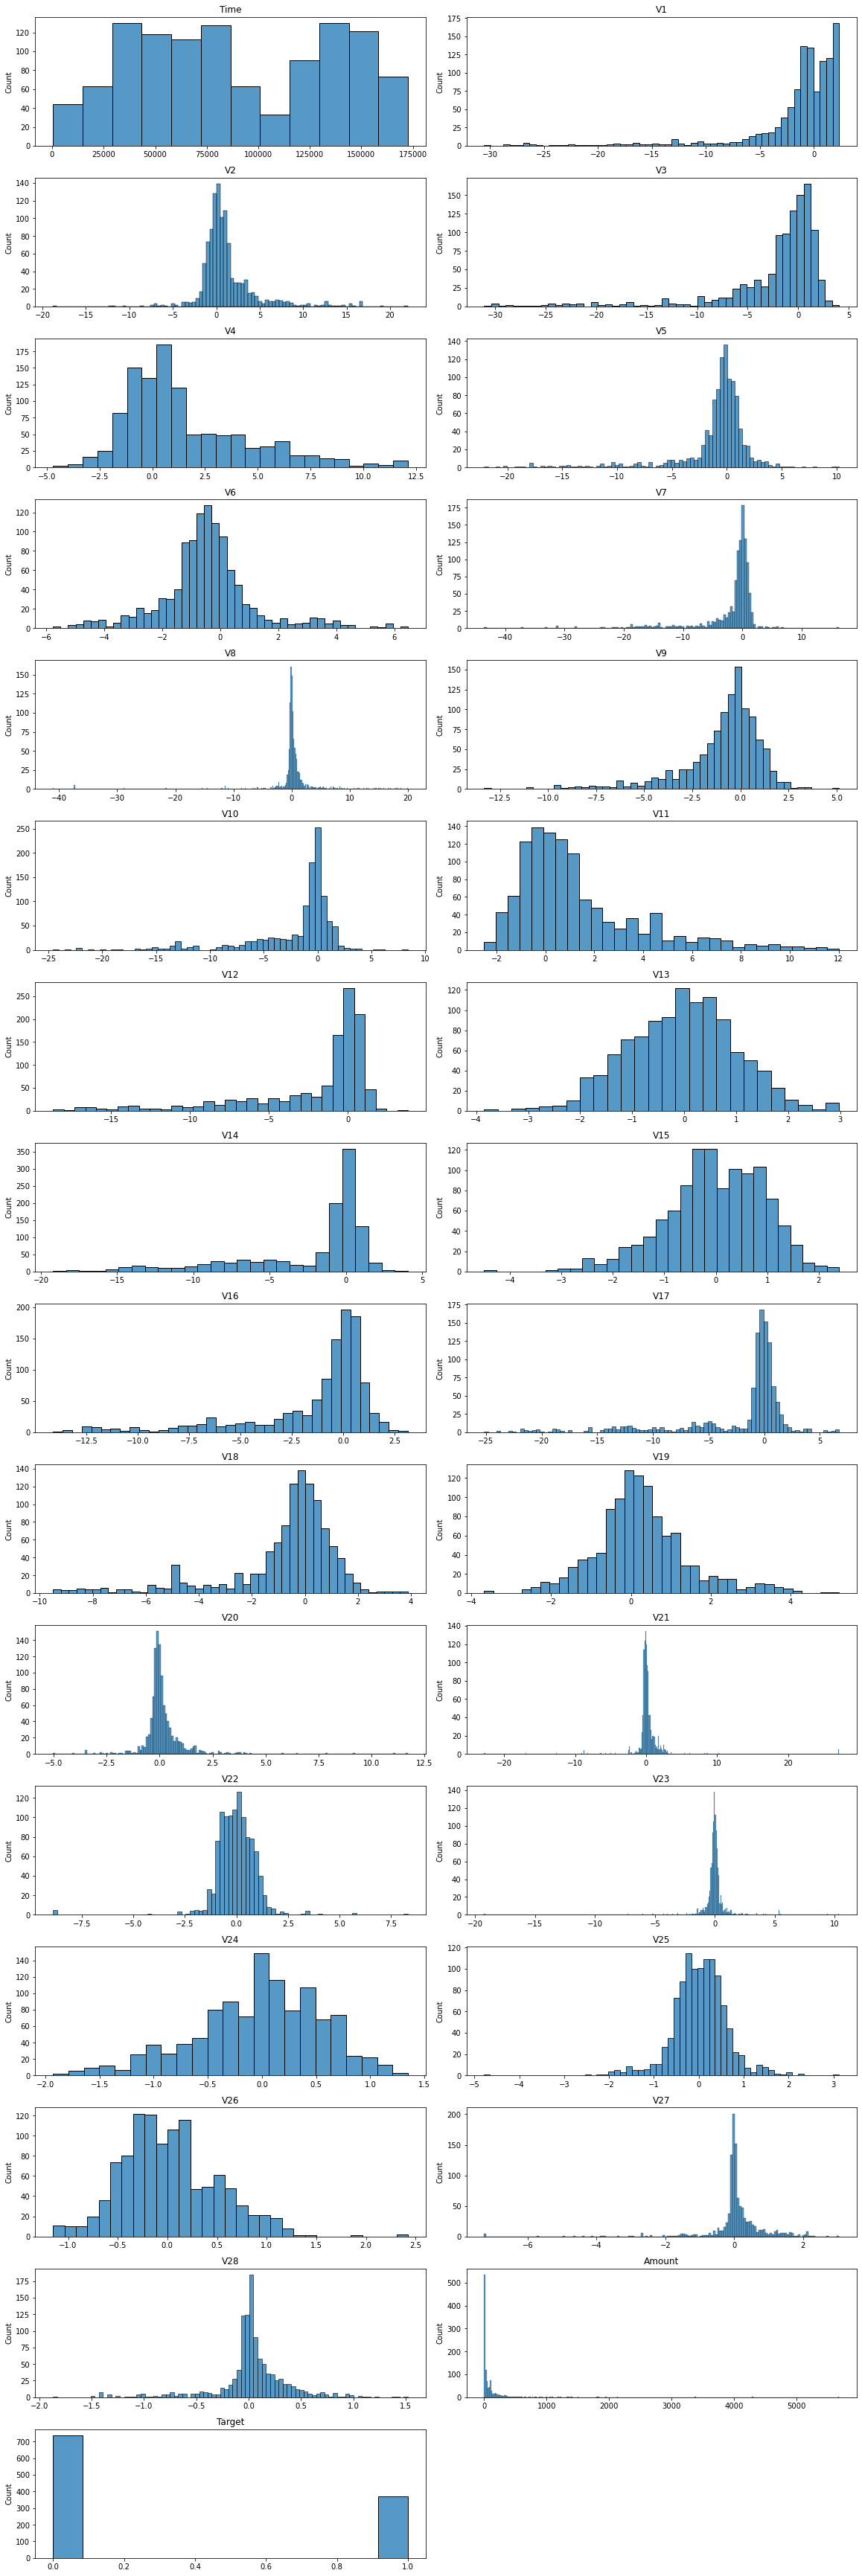

In [11]:
# plot histograms of the training data

ncol, nrow = 2, int(np.ceil(len(df_train.columns)/2))
figsize = (16,3*nrow)

plot_hist(df_train, figsize, nrow, ncol)

In [12]:
# scaling

for feature in df_train.columns:
    if feature in (categorical_features+["Target"]):
        continue
    else:
        lower = np.percentile(df_train[feature], 2)
        upper = np.percentile(df_train[feature], 95 if feature=="Amount" else 98)

    df_train.loc[df_train[feature]<lower, feature] = lower
    df_train.loc[df_train[feature]>upper, feature] = upper
    df_test.loc[df_test[feature]<lower, feature] = lower
    df_test.loc[df_test[feature]>upper, feature] = upper

scaler_list = [MinMaxScaler(clip=True), MinMaxScaler(clip=True)]   ### StandardScaler() / RobustScaler() / MinMaxScaler(clip=True)
feature_list = [continuous_features, categorical_features]
df_train_scaled, df_test_scaled = scale_features(df_train, df_test, feature_list, scaler_list)

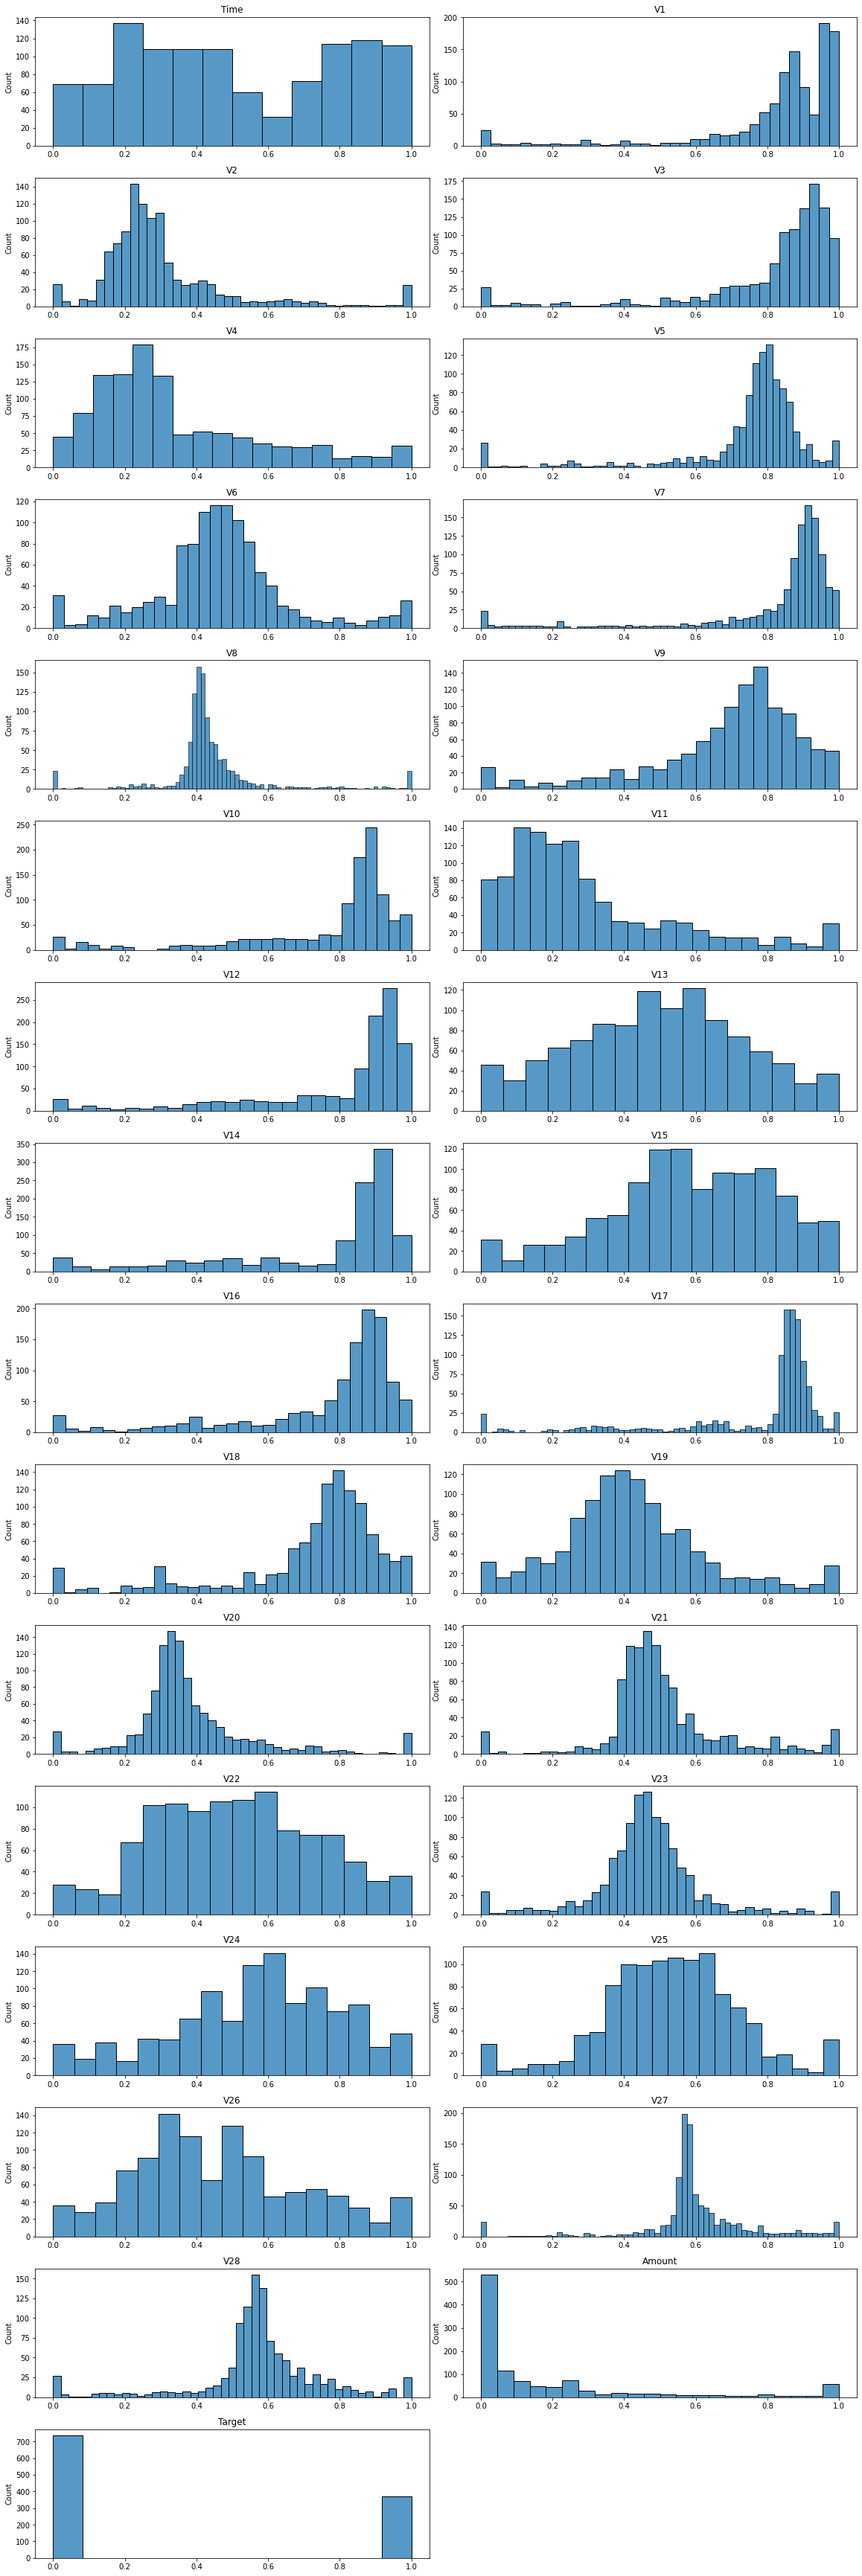

In [13]:
plot_hist(df_train_scaled, figsize, nrow, ncol)

In [14]:
df_train_scaled

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Target
0,0.074948,0.183139,0.730586,0.018588,1.000000,0.328149,0.238692,0.120598,0.447975,0.091542,0.081842,1.000000,0.078610,0.679934,0.007072,0.501583,0.274445,0.347303,0.304036,0.498558,0.579354,0.000000,0.844167,0.818181,0.151710,0.460325,0.781045,1.000000,0.000000,0.002534,1
1,0.204296,0.876334,0.304025,0.923287,0.260655,0.845633,0.582299,0.935800,0.443522,0.698991,0.853981,0.016330,0.915754,0.708563,0.928104,0.904707,0.863757,0.860982,0.815408,0.481161,0.339204,0.495175,0.635101,0.393001,0.044601,0.488958,0.340946,0.591102,0.606617,0.047884,0
2,0.797549,0.895853,0.422193,0.761608,0.715441,0.839513,0.438363,0.826573,0.222065,0.348662,0.746650,0.312603,0.702154,0.551673,0.598299,0.647146,0.673150,0.773991,0.695793,0.554333,0.626853,0.333155,0.866213,0.356435,0.463079,0.796825,0.869269,0.736390,0.880496,0.002534,1
3,0.020031,0.942711,0.481256,0.609471,0.830472,0.868905,0.169922,0.849073,0.437261,0.546888,0.632859,0.601861,0.468752,0.926169,0.296870,0.578811,0.780503,0.943964,0.942760,0.322625,0.473520,0.528763,0.527599,0.536921,0.409089,0.212700,0.688078,0.726529,0.645092,0.002534,1
4,0.000000,0.815931,0.433115,0.757675,0.432995,0.698832,0.188879,0.746608,0.512736,0.704123,0.507134,0.582610,0.432431,0.590362,0.477808,0.651708,0.647454,0.690338,0.678584,0.326560,0.433899,0.556274,0.329844,0.483967,0.773138,0.537124,0.606556,0.703397,0.691281,0.002534,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102,0.096588,0.871745,0.279437,0.982661,0.271081,0.847367,0.559967,0.955623,0.381026,0.937957,0.882712,0.374052,0.814325,0.807759,0.964141,0.179202,0.806525,0.896843,0.793981,0.364587,0.319215,0.426037,0.541649,0.403995,0.569032,0.559307,0.190502,0.412890,0.317279,0.000000,0
1103,0.761095,1.000000,0.161314,0.803435,0.060225,0.909636,0.921427,0.870019,0.464240,0.735210,0.931210,0.168788,0.899230,0.483197,0.900030,0.563381,0.910877,0.888995,0.592082,0.512507,0.367737,0.462301,0.460041,0.547446,0.874880,0.506228,0.294516,0.571809,0.526756,0.101342,0
1104,0.114250,0.000000,0.941515,0.035330,0.719488,0.000000,0.000000,0.161715,1.000000,0.348825,0.340758,0.722930,0.431343,0.543932,0.335664,0.586943,0.347732,0.281898,0.287417,0.604445,0.713431,0.814104,0.087420,0.223922,0.630488,0.962921,0.337623,0.964928,0.820809,0.253328,1
1105,0.246742,0.868682,0.278576,0.987359,0.185943,0.841521,0.517599,0.967246,0.373036,0.793806,0.933704,0.331277,0.932548,0.364330,0.879968,0.718934,0.858000,0.843896,0.769450,0.373154,0.398794,0.419856,0.433960,0.438992,0.577373,0.307244,0.416080,0.440227,0.304134,0.002255,0
